# Codec

We're going to see if FSQ is a good fit for finding the tokens we need for our model.

In [119]:
import jax
import equinox as eqx
import equinox.nn as nn
import jax.numpy as jnp

class Encoder(eqx.Module):
    conv0: nn.Conv1d
    conv1: nn.Conv1d
    conv2: nn.Conv1d
    conv3: nn.Conv1d
    conv4: nn.Conv1d
    conv7: nn.Conv1d

    def __init__(self, in_channels, hidden_channels, latent_channels, kernel_size=5, key=None):
        key0, key1, key2, key3, key4, key7 = jax.random.split(key, 6)
        self.conv0 = nn.Conv1d(
            in_channels,
            hidden_channels,
            kernel_size=kernel_size,
            stride=1,
            padding="SAME",
            use_bias=False,
            key=key0,            
        )
        self.conv1 = nn.Conv1d(
            hidden_channels * 1,
            hidden_channels * 4,
            kernel_size=kernel_size,
            stride=2,
            padding="SAME",
            key=key1,
        )
        self.conv2 = nn.Conv1d(
            hidden_channels * 4,
            hidden_channels * 8,
            kernel_size=kernel_size,
            stride=2,
            padding="SAME",
            key=key2,
        )
        self.conv3 = nn.Conv1d(
            hidden_channels * 8,
            hidden_channels * 16,
            kernel_size=kernel_size,
            stride=5,
            padding="SAME",
            key=key3,
        )
        self.conv4= nn.Conv1d(
            hidden_channels * 16,
            hidden_channels * 16,
            kernel_size=kernel_size,
            stride=5,
            padding="SAME",
            key=key4,
        )
        self.conv7 = nn.Conv1d(
            hidden_channels * 16, latent_channels, kernel_size=1, key=key7
        )

    @eqx.filter_jit
    def __call__(self, x):
        y = self.conv0(x)
        y = jax.nn.relu(y)
        y = self.conv1(y)
        y = jax.nn.relu(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.conv3(y)
        y = jax.nn.relu(y)
        y = self.conv4(y)
        y = jax.nn.relu(y)
        y = self.conv7(y)

        return y


class Decoder(eqx.Module):
    conv0: nn.ConvTranspose1d
    conv1: nn.ConvTranspose1d
    conv2: nn.ConvTranspose1d
    conv5: nn.ConvTranspose1d
    conv6: nn.ConvTranspose1d
    conv7: nn.ConvTranspose1d

    def __init__(self, in_channels, hidden_channels, latent_channels, kernel_size=5, key=None):
        key0, key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 8)
        self.conv0 = nn.ConvTranspose1d(
            latent_channels,
            hidden_channels * 16,
            kernel_size=kernel_size,
            stride=1,
            padding="SAME",
            key=key0,            
        )
        self.conv1 = nn.ConvTranspose1d(
            hidden_channels * 16,
            hidden_channels * 16,
            kernel_size=kernel_size,
            stride=5,
            padding="SAME",
            key=key1,
        )
        self.conv2 = nn.ConvTranspose1d(
            hidden_channels * 16,
            hidden_channels * 8,
            kernel_size=kernel_size,
            stride=5,
            padding="SAME",
            key=key2,
        )
        self.conv5= nn.ConvTranspose1d(
            hidden_channels * 8,
            hidden_channels * 4,
            kernel_size=kernel_size,
            stride=2,
            padding="SAME",
            key=key5,
        )
        self.conv6= nn.ConvTranspose1d(
            hidden_channels * 4,
            hidden_channels * 1,
            kernel_size=kernel_size,
            stride=2,
            padding="SAME",
            key=key6,
        )
        self.conv7 = nn.ConvTranspose1d(
            hidden_channels, in_channels, kernel_size=kernel_size, stride=1, use_bias=False, padding="SAME", key=key7
        )
    @eqx.filter_jit
    def __call__(self, x):
        y = self.conv0(x)
        y = jax.nn.relu(y)
        y = self.conv1(y)
        y = jax.nn.relu(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.conv5(y)
        y = jax.nn.relu(y)
        y = self.conv6(y)
        y = jax.nn.relu(y)
        y = self.conv7(y)

        return y


In [120]:
x = jax.random.normal(key=jax.random.key(1), shape=(1, 16000))
enc = Encoder(1, 4, 1, 5, key=jax.random.key(1))
dec = Decoder(1, 4, 1, 5, key=jax.random.key(1))

y = enc(x)
z = dec(y)

print(x.shape)
print(y.shape)
print(z.shape)

(1, 16000)
(1, 160)
(1, 16000)


We take the code from the google repo for the FSQ.

In [43]:

Codeword = jax.Array
Indices = jax.Array


class FSQ(eqx.Module):
    """Quantizer, taken from https://github.com/google-research/google-research/blob/master/fsq/fsq.ipynb"""

    _levels: list[int]
    _levels_np: jax.Array
    _eps: float
    _basis: jax.Array
    _implicit_codebook: jax.Array

    def __init__(self, levels: list[int], eps: float = 1e-3):
        self._levels = levels
        self._eps = eps
        self._levels_np = jnp.asarray(levels)
        self._basis = jnp.concatenate(
            (jnp.array([1]), jnp.cumprod(self._levels_np[:-1]))
        )

        self._implicit_codebook = self.indexes_to_codes(jnp.arange(self.codebook_size))

    @property
    def num_dimensions(self) -> int:
        """Number of dimensions expected from inputs."""
        return len(self._levels)

    @property
    def codebook_size(self):
        """Size of the codebook."""
        return jnp.prod(jnp.array(self._levels))

    @property
    def codebook(self):
        """Returns the implicit codebook. Shape (prod(levels), num_dimensions)."""
        return self._implicit_codebook

    @eqx.filter_jit
    def round_ste(self, z):
        """Round with straight through gradients."""
        zhat = jnp.round(z)
        return z + jax.lax.stop_gradient(zhat - z)

    @eqx.filter_jit
    def bound(self, z: jax.Array) -> jax.Array:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels_np - 1) * (1 - self._eps) / 2
        offset = jnp.where(self._levels_np % 2 == 1, 0.0, 0.5)
        shift = jnp.tan(offset / half_l)
        return jnp.tanh(z + shift) * half_l - offset

    @eqx.filter_jit
    def __call__(self, z: jax.Array) -> Codeword:
        """Quanitzes z, returns quantized zhat, same shape as z."""
        quantized = self.round_ste(self.bound(z))

        # Renormalize to [-1, 1].
        half_width = self._levels_np // 2
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized):
        # Scale and shift to range [0, ..., L-1]
        half_width = self._levels_np // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat):
        half_width = self._levels_np // 2
        return (zhat - half_width) / half_width

    def codes_to_indexes(self, zhat: Codeword) -> Indices:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.num_dimensions
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(axis=-1).astype(jnp.uint32)

    def indexes_to_codes(self, indices: Indices) -> Codeword:
        """Inverse of `indexes_to_codes`."""
        indices = indices[..., jnp.newaxis]
        codes_non_centered = jnp.mod(
            jnp.floor_divide(indices, self._basis), self._levels_np
        )
        return self._scale_and_shift_inverse(codes_non_centered)


class VQVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    quantizer: FSQ

    def __init__(self, in_channels, hidden_channels, latent_channels, levels, key=None):
        key1, key2 = jax.random.split(key)

        self.encoder = Encoder(in_channels, hidden_channels, latent_channels, key=key1)
        self.decoder = Decoder(in_channels, hidden_channels, latent_channels, key=key2)
        self.quantizer = FSQ(levels=levels)
        print("✅ Model initialized")

    @eqx.filter_jit
    def __call__(self, x):
        x = jnp.expand_dims(x, 0)
        
        z_e = self.encoder(x)
        reshaped_z_e = jnp.reshape(z_e, (-1, 5)) #16000 Hz -> 16Hz = 1000 points per code downsampled from 1000 to 5. Map each set of 5 to their respective code and map back. There are 4 levels thus 5 * (2 ** 4) = 80bits per codeword
        reshaped_z_q = self.quantizer(reshaped_z_e)
        z_q = jnp.reshape(reshaped_z_q, z_e.shape)
        y = self.decoder(z_q)
        # print(z_e)
        # print(z_e.shape)
        # print(reshaped_z_e.shape)
        # print(self.quantizer.codes_to_indexes(jnp.expand_dims(reshaped_z_q, -1)))
        y = jnp.squeeze(y)
        return y

In [44]:
x = jax.random.normal(key=jax.random.key(0), shape=(16000))
model = VQVAE(1, 4, 1, [4], key=jax.random.key(4))
y = model(x)
print(x.shape)
print(y.shape)
# print(z.shape)

✅ Model initialized
(16000,)
(16000,)


Let's train it and see what results we get !

✅ Model initialized


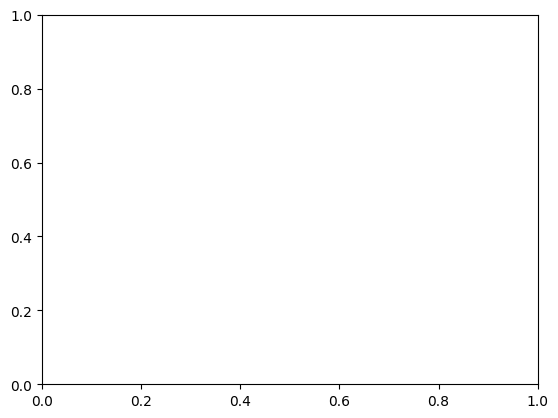

In [123]:
import optax
from tensorboardX import SummaryWriter
from datasets import load_dataset
import datetime

import jax
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
key1, key2 = jax.random.split(jax.random.key(2), 2)

model = VQVAE(1, 32, 4, [6], key=key1)

optimizer = optax.adam(1e-5)
opt_state = optimizer.init(model)

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
batch_size = 1
step = 0

dataset = load_dataset("blabble-io/libritts_r", "clean", streaming=True)

def cut_up(samples):
    list = []
    for sample in samples["audio"]:
        resampled = librosa.resample(sample["array"], orig_sr=22050, target_sr=16000)
        for i in range(0, (int(len(resampled)//16000) -1)):
            list.append(resampled[i*16000:i*16000+16000])
    return {"audio": list}

dataset = dataset.map(cut_up, batched=True, remove_columns=['text_normalized', 'text_original', 'speaker_id', 'path', 'chapter_id', 'id'])

dataloader= dataset["train.clean.360"].batch(batch_size=batch_size)


@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def calculate_losses(model, x):
    y = jax.vmap(model)(x)
    return jnp.mean(jnp.linalg.norm((x - y), ord=2, axis=(0, 1))), y

@eqx.filter_jit
def make_step(model, optimizer, opt_state, x):
    (total_loss, y), grads = (
        calculate_losses(model, x)
    )
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)

    return (
        model,
        opt_state,
        total_loss,
        y
    )
fig, ax = plt.subplots(1)
fig.show()
step = 0


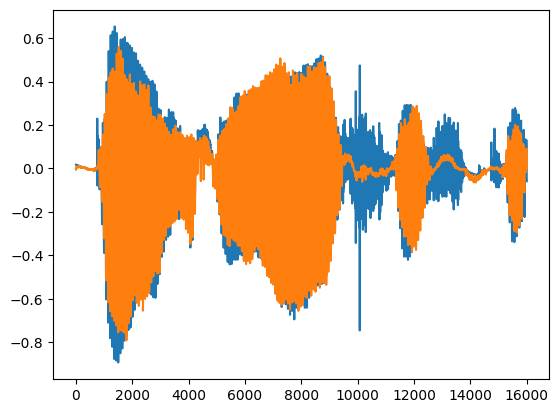

In [ ]:
for epoch in range(epochs):
    # eqx.tree_serialise_leaves(f"checkpoints/{epoch}.eqx", model)
    for batch in dataloader:
        input = jax.numpy.array(batch["audio"])
        model, opt_state, total_loss, y = make_step(model, optimizer, opt_state, input)

        # Log codebook updates to TensorBoard
        step+=1
        writer.add_scalar('Loss/Total', total_loss, step)
        if (step // batch_size) % 20 == 0:
            ax.clear()
            ax.plot(batch["audio"][0])
            ax.plot(y[0])
            display(fig)
            clear_output(wait=True)
            
    # plt.imshow(y[0])otal_loss}")

In [112]:
data = iter(dataloader)

In [113]:
sample = next(data)["audio"][0]
IPython.display.Audio(sample, rate=16000)


In [114]:

y = model(sample)
z = model.encoder(jnp.expand_dims(sample, 0))
codes = model.quantizer.codes_to_indexes(jnp.expand_dims(model.quantizer(z), -1))
print(codes)

IPython.display.Audio(y, rate=16000)

[[4 4 4 4 4 4 4 4 4 4 4 7 7 7 0 7 0 7 0 6 7 0 2 2 2 7 5 2 1 7 7 2 3 2 7 1
  5 5 4 4 4 4 4 4 1 3 7 7 3 2 1 7 2 1 7 3 1 7 2 0 7 2 1 7 2 0 7 4 1 1 7 3
  1 1 1 7 7 5 2 2]
 [4 4 4 4 4 3 4 4 3 4 4 2 1 0 0 7 0 7 0 5 5 0 2 5 2 0 2 7 4 0 1 2 7 2 1 6
  2 5 3 4 4 4 4 4 2 0 0 1 5 6 4 0 4 7 0 2 7 0 4 7 0 4 6 0 5 7 0 3 7 2 0 6
  6 7 0 0 5 4 5 6]
 [4 4 4 4 4 4 4 4 4 4 4 3 1 0 4 7 0 7 0 7 0 2 7 7 7 3 4 5 7 3 1 5 5 7 2 4
  4 4 4 4 4 4 4 4 5 6 1 0 5 4 7 1 5 4 6 3 3 6 6 6 2 6 7 1 6 6 4 2 3 7 0 6
  4 6 7 1 0 6 3 6]
 [4 4 4 4 4 4 4 4 4 4 3 5 6 5 2 1 7 1 7 0 7 3 0 0 2 4 6 1 1 3 7 5 0 3 6 2
  6 3 4 4 4 4 3 3 3 5 4 6 7 0 3 5 6 0 4 7 0 4 6 1 5 3 2 5 6 0 3 7 0 5 3 7
  0 0 6 2 7 7 2 2]
 [4 4 4 4 4 4 4 4 4 4 5 4 4 6 7 4 6 3 6 6 0 6 7 7 7 5 2 3 7 6 4 0 5 6 5 3
  5 5 4 4 4 4 4 4 6 4 2 3 2 2 7 2 1 7 5 2 6 5 1 7 5 0 7 5 0 7 3 2 2 7 2 2
  0 7 6 0 4 2 1 6]
 [4 4 3 3 3 3 4 4 4 3 4 4 4 7 2 0 7 0 7 1 4 4 3 3 6 4 0 1 5 7 0 1 1 7 1 1
  2 4 3 4 3 3 4 4 5 7 7 1 1 1 6 2 1 3 7 0 2 5 0 5 1 1 6 1 0 3 6 0 1 7 2 0
  2 4 7 6 1 0 1 3

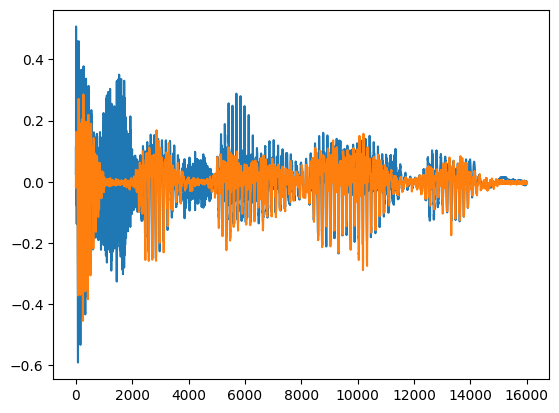

In [111]:
fig, ax = plt.subplots(1)
fig.show()
ax.plot(sample)
ax.plot(y)

In [ ]:
eqx.tree_serialise_leaves("checkpoints/fsq.eqx", model)